In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler

In [221]:
cars = pd.read_csv(
    "/Users/huzaifamalik/Downloads/Python for Data Science/Regression/Course Materials/Fuel Economy Guided Project/auto-mpg.csv",
    dtype={"origin": "object"}
)

In [222]:
cars.shape

(398, 9)

## Data Cleaning and Exploratory Data Analysis (EDA)

In [223]:
cars["horsepower"] = pd.to_numeric(cars["horsepower"], errors = "coerce")

In [224]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [225]:
#Check if there are any duplicates
cars.loc[cars.duplicated()]

#No duplicates present as no row is returned

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name


In [226]:
#Check for any missing values

cars.loc[cars.isna().any(axis = 1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,1,amc concord dl


In [227]:
#Six cars' hp is unknown so we will take the Mean of the horsepower column and fill na values with the mean hp

cars["horsepower"] = np.where(
    cars["horsepower"].isna(), cars["horsepower"].mean(), cars["horsepower"]
)

In [228]:
#Verification that there are no missing values now in dataset
cars.loc[cars.notna().all(axis = 1)].shape

(398, 9)

In [229]:
#Remove any unnecessary spaces from car names and make them all the same case so lower case here
cars["car name"] = cars["car name"].str.strip().str.lower()

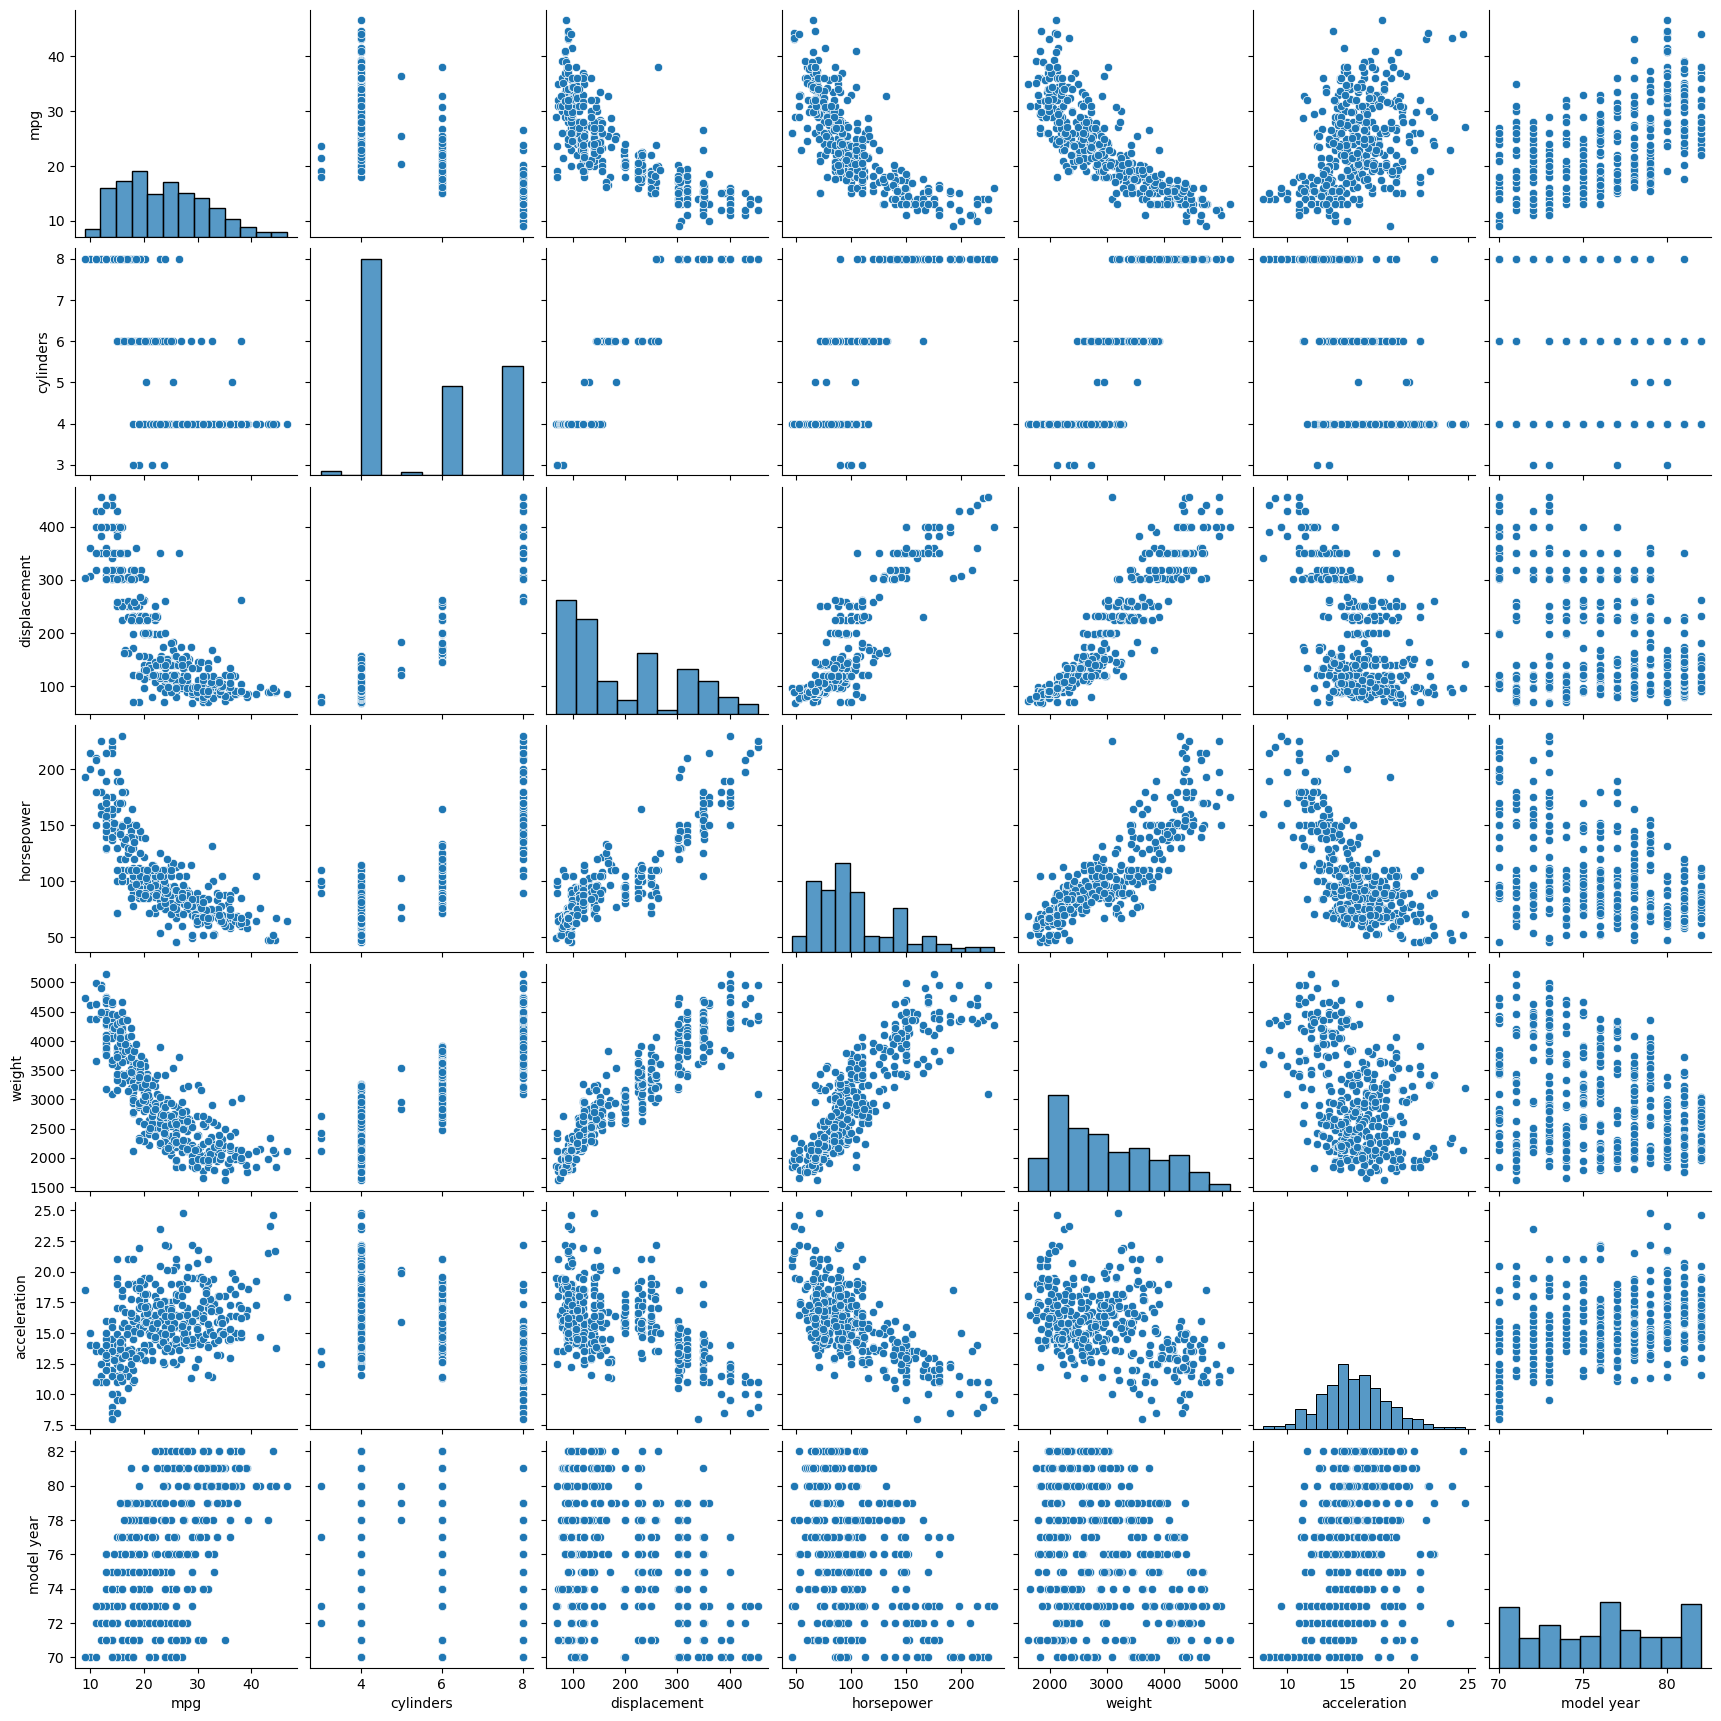

In [231]:
# Check for outliers using pairplot
sns.pairplot(cars);

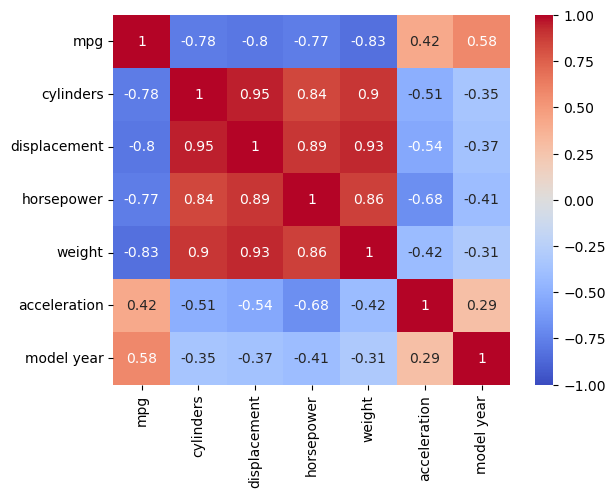

In [233]:
#Check for correlation between different features
sns.heatmap(cars.select_dtypes("number").corr(), vmin =-1, vmax =1, cmap="coolwarm", annot=True);

#Horsepower, Weight, Cylinders and Displacement Highly correlated with each other (0.84 to 0.95)

## Linear Regression (OLS) Method

In [234]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [266]:
features = [
    "horsepower", "weight", "horsepower_sq", "weight_sq", "acceleration", "acceleration_sq",
    "model year", "origin"
    
]

cars_copy = cars.assign(
    displacement_sq = cars["displacement"] ** 2,
    displacement_cube = cars["displacement"] ** 3,
    
    horsepower_sq = cars["horsepower"] ** 2,
    horsepower_cube = cars["horsepower"] ** 3,
    
    weight_sq = cars["weight"] ** 2,
    weight_cube = cars["weight"] ** 3,
    
    acceleration_sq = cars["acceleration"] ** 2,
    acceleration_cube = cars["acceleration"] ** 3
)

X = sm.add_constant(pd.get_dummies(cars_copy.loc[:, features], drop_first=True, dtype=int))
y = cars_copy["mpg"]
#y = np.log(cars_copy["mpg"])

model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     283.6
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          1.25e-164
Time:                        17:50:49   Log-Likelihood:                -979.53
No. Observations:                 398   AIC:                             1979.
Df Residuals:                     388   BIC:                             2019.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              18.9600      5.946      3.189      0.002       7.269      30.650
horsepower         -0.1201      0.036     -3.340      0.001      -0.191      -0.049
weight             -0.0168      0.002     -8.813      0.000      -0.021      -0.013
horsepower_sq       0.0003      0.000      2.527      0.012    6.75e-05       0.001
weight_sq        1.881e-06   2.74e-07      6.860      0.000    1.34e-06    2.42e-06
acceleration       -1.9736      0.516     -3.825      0.000      -2.988      -0.959
acceleration_sq     0.0565      0.015      3.655      0.000       0.026       0.087
model year          0.8080      0.044     18.346      0.000       0.721       0.895
origin_2            1.1767      0.450      2.614      0.009       0.292       2.062
origin_3            1.2106      0.466      2.598      0.010       0.294       2.127
==============================================================================
Omnibus:                       31.724   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.463
Skew:                           0.426   Prob(JB):                     8.25e-16
Kurtosis:                       4.861   Cond. No.                     4.55e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

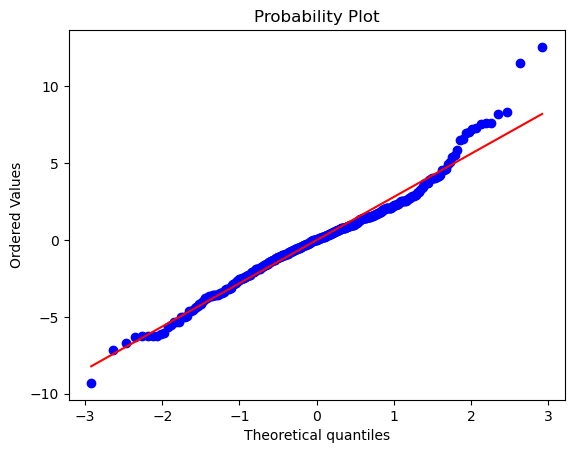

In [257]:
#Check for normality of errors/residue
stats.probplot(model.resid, dist = "norm", plot = plt);

In [258]:
#check for Multi collinearity using VIF. It will be very high because of polynomial terms
vif_values_list = []

for i in range(0, X.shape[1]):
    vif_values_list.append(vif(X.values, i))

pd.DataFrame(
    {
        "Column_Name": X.columns,
        "VIF": vif_values_list
    }
)

,Column_Name,VIF
0,const,1706.286224
1,horsepower,90.886951
2,weight,125.260473
3,horsepower_sq,66.122950
4,weight_sq,107.624664
5,acceleration,97.458581
6,acceleration_sq,90.678136
7,model year,1.276784
8,origin_2,1.417174
9,origin_3,1.667130


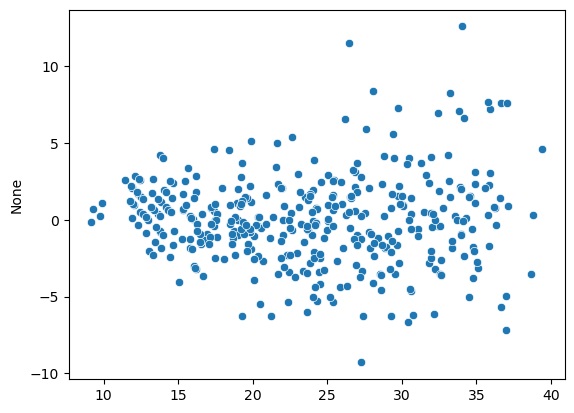

In [259]:
#Check for Residue/Errors with scatterplot
sns.scatterplot(x = model.predict(), y = model.resid);

In [260]:
#Find Cook's distance to see for any outliers and if they overfit the model
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df.head(2)

,dfb_const,dfb_horsepower,dfb_weight,dfb_horsepower_sq,dfb_weight_sq,dfb_acceleration,dfb_acceleration_sq,dfb_model year,dfb_origin_2,dfb_origin_3,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.129769,0.004927,0.052337,-0.037839,-0.047039,-0.101640,0.086901,-0.123330,-0.035190,0.000686,0.004853,1.489398,0.021410,0.220303,1.491748,0.220650
1,0.033599,0.018554,0.026267,-0.008318,-0.038080,-0.031465,0.031066,-0.049426,-0.014879,-0.002779,0.001585,0.910089,0.018772,0.125879,0.909887,0.125851


In [261]:
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

330    0.079619
326    0.072411
394    0.046521
59     0.044508
327    0.035944
Name: cooks_d, dtype: float64

In [262]:
#Perform cross validation on linear regression model

kf = KFold(n_splits = 5, shuffle = True, random_state=2023)

r2_scores_list = []
mae_list = []

for train_index, test_index in kf.split(X,y):
    
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    
    train_model = sm.OLS(y_train, X_train).fit()
    y_predicted = train_model.predict(X_test)
    
    r2_scores_list.append(r2(y_test, y_predicted))
    mae_list.append(mae(y_test, y_predicted))
    
print(f"R2 Scores: {r2_scores_list}")
print(f"Avg R2 Score: {np.mean(r2_scores_list)}")
print("\n")
print(f"MAE Scores: {mae_list}")
print(f"Avg MAE Score: {np.mean(mae_list)}")

R2 Scores: [0.8146369233737069, 0.8698740573554578, 0.8467564051874499, 0.869841272426752, 0.8774759529920731]
Avg R2 Score: 0.855716922267088


MAE Scores: [2.231845537443973, 2.175263456560313, 2.1540013264837183, 2.1489746169114623, 2.058435667645389]
Avg MAE Score: 2.153704121008971


## RidgeCV Model

In [263]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-1, 2, n_alphas)

ridge_model = RidgeCV(alphas=alphas, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Ridge Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Ridge Train R²: {train_r2:.4f}")
print(f"Ridge Test R²: {test_r2:.4f}")
print(f"Ridge Train MAE: {train_mae:.2f}")
print(f"Ridge Test MAE: {test_mae:.2f}")

Ridge Optimal Alpha: 0.1000
Ridge Train R²: 0.8778
Ridge Test R²: 0.8158
Ridge Train MAE: 2.07
Ridge Test MAE: 2.22


## LassoCV Model

In [264]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-1, 2, n_alphas)

lasso_model = LassoCV(alphas=alphas, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Lasso Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Lasso Train R²: {train_r2:.4f}")
print(f"Lasso Test R²: {test_r2:.4f}")
print(f"Lasso Train MAE: {train_mae:.2f}")
print(f"Lasso Test MAE: {test_mae:.2f}")

Lasso Optimal Alpha: 0.1000
Lasso Train R²: 0.8358
Lasso Test R²: 0.7808
Lasso Train MAE: 2.42
Lasso Test MAE: 2.58


## ElasticNetCV Model

In [265]:
#1 Split into train/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#2 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#3 Define RidgeCv with multiple alphas
n_alphas = 200
alphas = 10 ** np.linspace(-1, 2, n_alphas)
l1_ratios=np.linspace(0.1, 1.0, 10)

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio= l1_ratios, cv = 5).fit(X_train_scaled,y_train)

#4 Predictions
y_train_pred = elastic_model.predict(X_train_scaled)
y_test_pred = elastic_model.predict(X_test_scaled)


#5 Evaluation metrics
train_r2 = r2(y_train, y_train_pred)
test_r2 = r2(y_test, y_test_pred)
train_mae = mae(y_train, y_train_pred)
test_mae = mae(y_test, y_test_pred)

#6 Print results
print(f"Elastic Net Optimal Alpha: {ridge_model.alpha_:.4f}")
print(f"Elastic Net Optimal L1 Ratio: {elastic_model.l1_ratio_:.2f}")
print(f"Elastic Net Train R²: {train_r2:.4f}")
print(f"Elastic Net Test R²: {test_r2:.4f}")
print(f"Elastic Net Train MAE: {train_mae:.2f}")
print(f"Elastic Net Test MAE: {test_mae:.2f}")

Elastic Net Optimal Alpha: 0.1000
Elastic Net Optimal L1 Ratio: 0.80
Elastic Net Train R²: 0.8356
Elastic Net Test R²: 0.7856
Elastic Net Train MAE: 2.42
Elastic Net Test MAE: 2.54
